# Часть 1. Books — Проверка гипотезы о различии активности пользователей из Москвы и Санкт-Петербурга

## Проверка гипотезы гипотезы в Python и составление аналитической записки
- Автор: Сорокин Елисей 

### Цели и задачи проекта

- Цель:
     - Проверить статистическую гипотезу о том, что пользователи из Санкт-Петербурга проводят в приложении Яндекс Книги больше времени, чем пользователи из Москвы.

- Задачи:

    - Загрузить и предобработать данные.

    - Проверить данные на дубликаты.

    - Провести односторонний t-тест на равенство средних значений.

    - Сделать выводы по результатам тестирования.

### Описание данных

Данные загружены из файла yandex_knigi_data.csv. Таблица содержит следующие поля:

- city — город пользователя;

- puid — уникальный идентификатор пользователя;

- hours — общее время активности пользователя в приложении в часах.

### Содержимое проекта

- Загрузка и предобработка данных.

- Проверка на дубликаты пользователей.

- Формирование выборок по городам.

- Проведение t-теста.

- Интерпретация результатов.

- Написание аналитической записки.
---

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd 
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_effectsize

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
df.tail()

,Unnamed: 0,city,puid,hours
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841
8783,8783,Санкт-Петербург,1130000061443598,20.847222


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [6]:
df = df.drop('Unnamed: 0', axis='columns')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


## Проверка на дубликаты 

In [8]:
dup = df[df['puid'].duplicated(keep = False)].sort_values('puid')
dup

,city,puid,hours
6247,Санкт-Петербург,2637041,3.883926
35,Москва,2637041,10.317371
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
...,...,...,...
8773,Санкт-Петербург,1130000020425037,2.386944
6202,Москва,1130000023864516,142.830085
8775,Санкт-Петербург,1130000023864516,14.384722
8779,Санкт-Петербург,1130000028554332,4.107774


In [9]:
book_df = df.drop_duplicates(subset=['puid'])
book_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8540 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8540 non-null   object 
 1   puid    8540 non-null   int64  
 2   hours   8540 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 266.9+ KB


## Формирование выборок по городам

In [10]:
spb = book_df[(book_df['city'] == 'Санкт-Петербург')]
msk = book_df[(book_df['city'] == 'Москва')] 

In [11]:
a_users = spb['puid']
b_users = msk['puid']

intersection = set(a_users) & set(b_users)

print(f'Количество пользователей, которые встречаются одновременно в Санкт-Петербурге и Москве: {len(intersection)}')

Количество пользователей, которые встречаются одновременно в Санкт-Петербурге и Москве: 0


In [12]:
spb_count = spb['puid'].nunique()
msk_count = msk['puid'].nunique()
print(f'Количество уникальных пользователей в Санкт-Петербурге: {spb_count}')
print(f'Количество уникальных пользователей в Москве: {msk_count}')

Количество уникальных пользователей в Санкт-Петербурге: 2306
Количество уникальных пользователей в Москве: 6234


<function matplotlib.pyplot.show(close=None, block=None)>

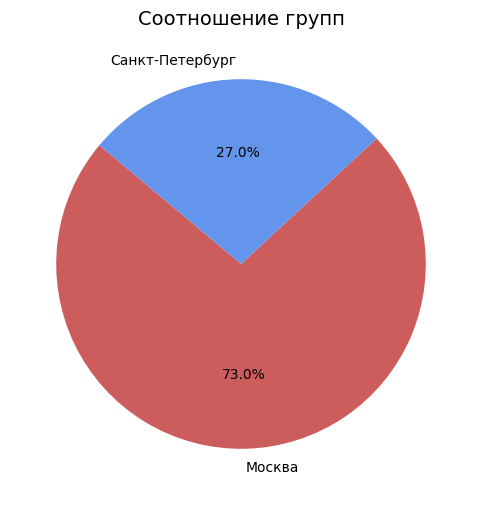

In [13]:
city_test_count = book_df.groupby('city')['puid'].nunique()
city_test_count.plot(kind='pie',
                  figsize = (12,6),
                  labels=['Москва','Санкт-Петербург'],
                  autopct='%1.1f%%',
                  startangle=140,
                  colors=['indianred', 'cornflowerblue']
)
plt.title('Соотношение групп', fontsize=14)
plt.ylabel('')
plt.show

C:\Users\elise\AppData\Local\Temp\ipykernel_19668\489142889.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=book_df,


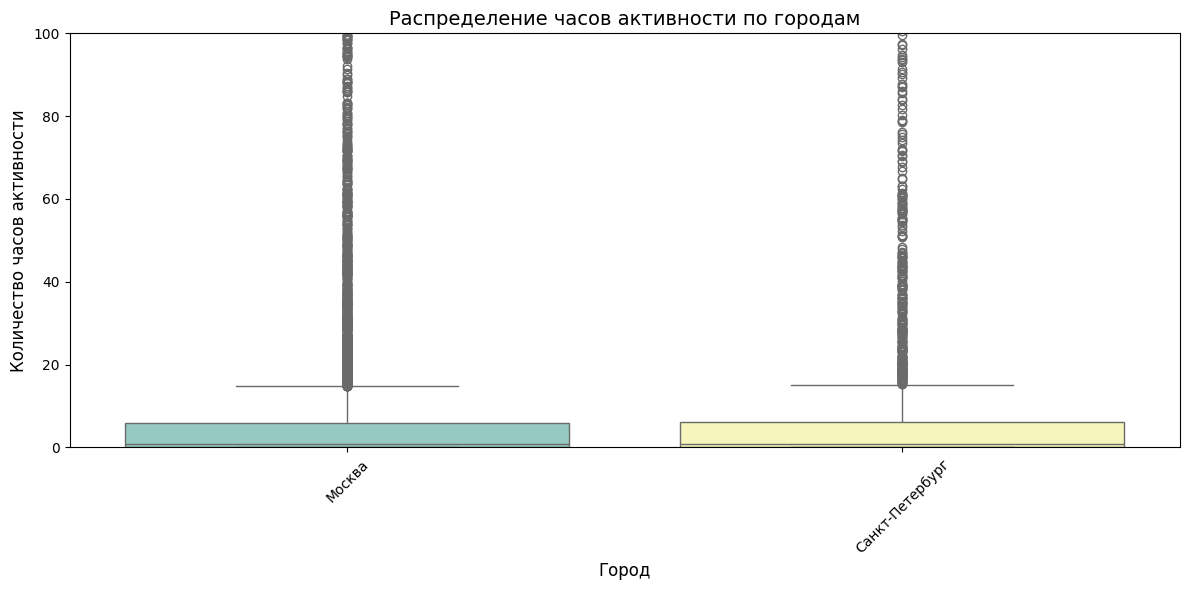

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=book_df,
            x='city',
            y='hours',
            palette='Set3'
)
plt.xticks(rotation=45)
plt.title('Распределение часов активности по городам', fontsize=14)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Количество часов активности', fontsize=12)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [15]:
group_stats = book_df.groupby('city')['hours'].describe()
print(group_stats)

                  count       mean        std       min       25%       50%  \
city                                                                          
Москва           6234.0  10.881092  36.851683  0.000018  0.059903  0.924498   
Санкт-Петербург  2306.0  11.264433  39.831755  0.000025  0.060173  0.875355   

                      75%         max  
city                                   
Москва           5.939972  857.209373  
Санкт-Петербург  6.138424  978.764775  


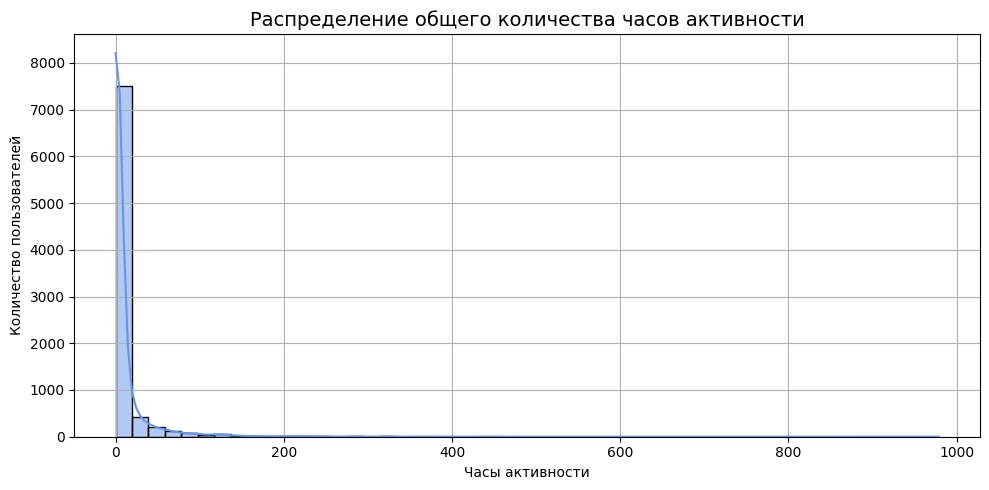

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(book_df['hours'],
             bins=50,
             kde=True,
             color='cornflowerblue'
)

plt.title('Распределение общего количества часов активности', fontsize=14)
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.tight_layout()
plt.show()

## Вывод по распределению часов активности и его влиянию на исследование
Особенности распределения часов активности


- Распределение по обоим городам (Москва и Санкт-Петербург) имеет:

    - Сильно сдвинутую форму (асимметрию) — большинство пользователей проводят мало времени, но есть значительные выбросы (максимумы выше 850–900 часов).

    - Среднее значение сильно превышает медиану, что подтверждает влияние выбросов.

        - Москва: среднее — ~10.9 ч, медиана — ~0.9 ч.

        - СПб: среднее — ~11.3 ч, медиана — ~0.87 ч.


- Распределение пользователей между городами

    - Москва: 6234 пользователей

    - Санкт-Петербург: 2306 пользователей


- Как это может повлиять на тест

    - Если доля москвичей и петербуржцев неравномерно распределена по тестовым группам, то:

    - Полученные различия в метриках могут быть связаны не с воздействием эксперимента, а с географическими особенностями поведения.

    - Поэтому важно дополнительно проверить, как города распределены по группам A и B, чтобы исключить конфоундинг-фактор.
    

- Предобработка данных

    - Размер исходных данных: 8784 записей.

    - Найдено 244 дубликата пользователей по puid — удалены.

    - Итоговый объём данных: 8540 пользователей.

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [17]:
sample_a = spb['hours']
sample_b = msk['hours']

alpha = 0.05

stat_ttest, p_value_ttest = ttest_ind(
    sample_a,
    sample_b,
    alternative='greater',
    equal_var=False)

print(f'T-статистика: {stat_ttest:.3f}')
print(f'P-value (односторонний): {p_value_ttest:.4f}')

if p_value_ttest < alpha:
    print('Отвергаем нулевую гипотезу: пользователи из Санкт-Петербурга проводят больше времени в приложении.')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу: различие не является статистически значимым.')

T-статистика: 0.403
P-value (односторонний): 0.3436
Недостаточно оснований отвергнуть нулевую гипотезу: различие не является статистически значимым.


In [18]:
print("Среднее время активности пользователей в СПб:", sample_a.mean())
print("Среднее время активности пользователей в Москве:", sample_b.mean())

Среднее время активности пользователей в СПб: 11.264433367029522
Среднее время активности пользователей в Москве: 10.88109206345796


In [19]:
print("Медианное время активности пользователей в СПб:", sample_a.median())
print("Медианное время активности пользователей в Москве:", sample_b.median())

Медианное время активности пользователей в СПб: 0.8753550505050504
Медианное время активности пользователей в Москве: 0.9244980209724304


## П.С Тест Манна–Уитни

In [20]:
stat_mw, p_value_mw = mannwhitneyu(
    sample_a,
    sample_b,
    alternative='greater')

print(f'U-статистика: {stat_mw}')
print(f'P-value (односторонний): {p_value_mw:.4f}')

if p_value_mw < alpha:
    print('Отвергаем нулевую гипотезу: пользователи из Санкт-Петербурга проводят больше времени в приложении.')
else:
    print('Недостаточно оснований отвергнуть нулевую гипотезу: различие не является статистически значимым.')

U-статистика: 7157178.5
P-value (односторонний): 0.6190
Недостаточно оснований отвергнуть нулевую гипотезу: различие не является статистически значимым.


## Аналитическая записка

- Гипотезы:

    - H₀ (нулевая): среднее время активности пользователей из Санкт-Петербурга не больше, чем у пользователей из Москвы.

    - H₁ (альтернативная): среднее время активности пользователей из Санкт-Петербурга больше, чем у пользователей из Москвы.


- Тип теста:

    - Независимый односторонний t-тест, так как сравниваются две независимые выборки пользователей.

- Уровень значимости:
    α = 0.05

- Результаты теста:
    T-статистика: 0.403

- P-value: 0.3436


- Средняя активность:

    - СПб: 11.26 часов

    - Москва: 10.88 часов


- Медианное время активности:

    - СПб: 0.87 часов

    - Москва: 0.92 часов



- Вывод:

    - Несмотря на то, что среднее в СПб было выше (11.26 против 10.88 часов), медиана наоборот — чуть выше в Москве. Это говорит о влиянии редких, но очень длинных сессий в Санкт-Петербурге, которые завышают среднее.

    - Распределения асимметричны и с длинным "хвостом" — особенно у СПб.

    - Поэтому медиана более устойчива и, похоже, говорит о том, что типичный пользователь из Москвы активнее, пусть и ненамного.


- Вывод T-тест:
P-value выше α, поэтому нет оснований отвергнуть нулевую гипотезу.
То есть статистически нельзя утверждать, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы.


- Возможные причины таких результатов
    - Схожее поведение пользователей: аудитория в двух городах может иметь одинаковые привычки потребления контента.

    - Шум в данных: присутствие пользователей с аномальной активностью (например, >100 часов), может влиять на средние значения.
    
    - Выборка из СПб в 3 раза меньше, что снижает статистическую мощность теста — но даже так, различие не просматривается.


- П.С. Тест Манна–Уитни
    - P-value = 0.6190 — намного выше порогового значения α = 0.05, поэтому нет оснований отвергнуть нулевую гипотезу.

    - Даже при использовании более гибкого и надёжного теста Манна–Уитни различия между Санкт-Петербургом и Москвой по времени активности статистически незначимы.


----

# Часть 2. Conversion — Анализ результатов A/B-тестирования интерфейса интернет-магазина BitMotion Kit

## Анализ результатов A/B-тестирования
- Автор: Сорокин Елисей 

### Цели и задачи проекта

- Цель:
    - Оценить влияние новой версии интерфейса интернет-магазина BitMotion Kit на поведение пользователей и проверить, приводит ли она к увеличению доли покупок.

- Задачи:
    - Загрузить и изучить предоставленные данные.

    - Проверить корректность проведения A/B-теста (разделение пользователей, длительность, пересечения).

    - Сформировать выборки и рассчитать ключевую метрику — конверсию.

    - Провести статистическую проверку гипотез.

    - Сделать выводы и сформулировать рекомендации.


### Описание данных
В рамках A/B-теста интернет-магазина BitMotion Kit доступны две таблицы:

- Таблица participants — информация об участниках эксперимента:

    - user_id — уникальный идентификатор пользователя;

    - group — группа участия;

    - ab_test — название теста;

    - device — устройство, с которого пользователь зашёл на сайт.

    - Размер таблицы: 14 525 строк, пропусков нет.


- Таблица events — события, зафиксированные на сайте:

    - user_id — уникальный идентификатор пользователя;

    - event_dt — дата и время события;

    - event_name — тип события;

    - details — дополнительные данные по событию.

    - Размер таблицы: 787 286 строк, пропуски есть только в поле details, что не критично для анализа поведения.



## Загрузка данных и знакомство с ними 


In [21]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [22]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [23]:
participants.tail()

,user_id,group,ab_test,device
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14522,FFF28D02B1EACBE1,B,recommender_system_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC
14524,FFF58BC33966EB51,A,interface_eu_test,Android


In [24]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [25]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [26]:
events.tail()

,user_id,event_dt,event_name,details
787281,1A655C280B064708,2020-12-31 23:57:44,product_page,NaN
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0
787283,GLOBAL,2020-12-31 23:58:30,product_cart,NaN
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52
787285,5456977474344433,2020-12-31 23:59:48,registration,-3.67


In [27]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


## Выводы по структуре данных

- participants содержит 14 525 записей об участии пользователей в A/B-тестах. Один пользователь может участвовать в нескольких тестах — это требует фильтрации по нужному ab_test.


- events — 787 286 событий. Присутствуют глобальные (user_id = GLOBAL) и пользовательские события. У многих событий пустой details, что нормально.


- Есть пользователи, участвующие в обеих группах одного теста — такие случаи нужно исключить для корректного анализа.

## Проверка корректность проведения A/B-теста (разделение пользователей, длительность, пересечения).


In [28]:
tests_per_user = participants.groupby('user_id')['ab_test'].nunique()
users_in_multiple_tests = tests_per_user[tests_per_user > 1]
print(f'Число пользователей, участвующих в нескольких тестах: {users_in_multiple_tests.shape[0]}')

Число пользователей, участвующих в нескольких тестах: 887


In [29]:
users_to_exclude = users_in_multiple_tests.index
clean_test_participants = participants[~participants['user_id'].isin(users_to_exclude)]

In [30]:
clean_test_participants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12751 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  12751 non-null  object
 1   group    12751 non-null  object
 2   ab_test  12751 non-null  object
 3   device   12751 non-null  object
dtypes: object(4)
memory usage: 498.1+ KB


In [31]:
interface_test_participants = clean_test_participants[(clean_test_participants['ab_test'] == 'interface_eu_test')]

In [32]:
dup_part = interface_test_participants[interface_test_participants['user_id'].duplicated(keep = False)].sort_values('user_id')
dup_part

,user_id,group,ab_test,device


In [33]:
users_count_by_group = interface_test_participants.groupby('group')['user_id'].nunique()

for group in ['A', 'B']:
    print(f"Количество уникальных пользователей в группе {group}: {users_count_by_group.get(group, 0)}")

Количество уникальных пользователей в группе A: 4952
Количество уникальных пользователей в группе B: 5011


In [34]:
total_users = interface_test_participants['user_id'].nunique()

users_count_perc = (users_count_by_group / total_users) * 100

for group in ['A', 'B']:
    print(f'Процентная разница в количестве пользователей в группе {group}: {users_count_perc.get(group, 0):.1f}%')

Процентная разница в количестве пользователей в группе A: 49.7%
Процентная разница в количестве пользователей в группе B: 50.3%


<function matplotlib.pyplot.show(close=None, block=None)>

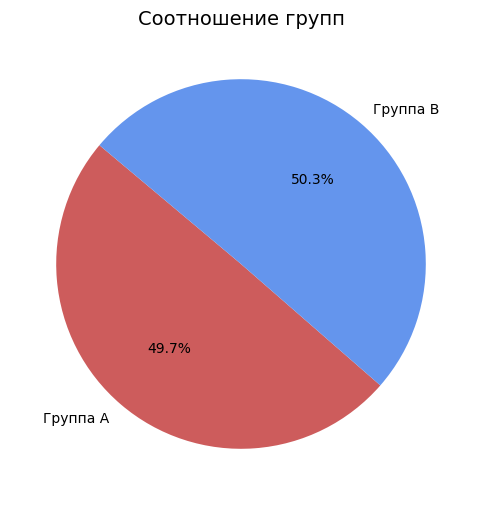

In [35]:
users_count_by_group.plot(kind='pie',
                  figsize = (12,6),
                  labels=['Группа A', 'Группа В'],
                  autopct='%1.1f%%',
                  startangle=140,
                  colors=['indianred', 'cornflowerblue']
)
plt.title('Соотношение групп', fontsize=14)
plt.ylabel('')
plt.show

In [36]:
a_users = interface_test_participants[(interface_test_participants['group'] == 'A')]['user_id']
b_users = interface_test_participants[(interface_test_participants['group'] == 'B')]['user_id']

intersection = set(a_users) & set(b_users)

print(f'Количество пользователей, которые встречаются одновременно в группах A и B: {len(intersection)}')

Количество пользователей, которые встречаются одновременно в группах A и B: 0


In [37]:
ab_test_events = events[events['user_id'].isin(interface_test_participants['user_id'])]

In [38]:
registration = ab_test_events.groupby('user_id')['event_dt'].min().reset_index()
registration.columns = ['user_id', 'registration_dt']

events_lifetime = ab_test_events.merge(registration, on='user_id')

In [39]:
events_lifetime['lifetime'] = (events_lifetime['event_dt'] - events_lifetime['registration_dt']).dt.days

In [40]:
analysis_events = events_lifetime[events_lifetime['lifetime'] < 7]

In [41]:
num_users = analysis_events['user_id'].nunique()

alpha = 0.05         
power = 0.8          
p1 = 0.3            
p2 = 0.33           

effect_size = proportion_effectsize(p1, p2)

analysis = NormalIndPower()
sample_size = analysis.solve_power(effect_size=effect_size,
                                   power=power,
                                   alpha=alpha,
                                   alternative='two-sided')

print(f'Необходимое количество пользователей в каждой группе: {round(sample_size)}')
print(f'Итого минимум пользователей: {round(sample_size * 2)}')
print(f'\nОбщее количество уникальных пользователей, участвующих в тесте: {num_users}')

Необходимое количество пользователей в каждой группе: 3762
Итого минимум пользователей: 7523

Общее количество уникальных пользователей, участвующих в тесте: 9963


In [42]:
purchase_events = analysis_events[analysis_events['event_name'] == 'purchase']

purchase_data = pd.merge(purchase_events, interface_test_participants[['user_id', 'group']], on='user_id', how='left')

purchases_by_group = purchase_data.groupby('group')['user_id'].nunique()

purchases_cr = (purchases_by_group / users_count_by_group)*100

for group in ['A', 'B']:
    print(f"\nКоличество пользователей, сделавших покупку в группе {group}: {purchases_by_group.get(group, 0)}")
    print(f"Общее количество пользователей в группе {group}: {users_count_by_group.get(group, 0)}")
    print(f"Конверсия в покупку в группе {group}: {purchases_cr.get(group, 0):.1f}%")


Количество пользователей, сделавших покупку в группе A: 1377
Общее количество пользователей в группе A: 4952
Конверсия в покупку в группе A: 27.8%

Количество пользователей, сделавших покупку в группе B: 1480
Общее количество пользователей в группе B: 5011
Конверсия в покупку в группе B: 29.5%


##  Предварительный общий вывод
- Тестовая группа (группа B) показала некоторое улучшение по сравнению с контрольной группой (группа A).

- Конверсия в покупку в группе B составила 29.5%, что на 1.7% больше, чем в контрольной группе, где этот показатель равен 27.8%.

- Это улучшение в 1.7% может указывать на успешность изменения, которое было внедрено в тестовой группе, однако для статистической уверенности требуется проведение соответствующего статистического теста для проверки значимости различий.

## 4. Оценка результатов A/B-тестирования:

In [43]:
n_a = interface_test_participants[interface_test_participants.group == 'A'].shape[0]
n_b = interface_test_participants[interface_test_participants.group == 'B'].shape[0]

m_a = purchase_data[purchase_data.group == 'A']['user_id'].nunique()
m_b = purchase_data[purchase_data['group'] == 'B']['user_id'].nunique()

p_a = m_a/n_a
p_b = m_b/n_b 
diff = p_b - p_a

print(f'Доля пользователей, сделавших покупку в группе A: {p_a:.3f}')
print(f'Доля пользователей, сделавших покупку в группе B: {p_b:.3f}')
print(f'Разница в доле пользователей, сделавших покупку (B - A): {diff:.3f}')

Доля пользователей, сделавших покупку в группе A: 0.278
Доля пользователей, сделавших покупку в группе B: 0.295
Разница в доле пользователей, сделавших покупку (B - A): 0.017


In [44]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print("Гипотезы:")
print(" - H₀ (нулевая гипотеза): конверсия в группе B меньше или равна конверсии в группе A (p_B ≤ p_A)")
print(" - H₁ (альтернативная гипотеза): конверсия в группе B больше, чем в группе A (p_B > p_A)")
print(f"\np-value: {p_value_ztest:.4f}")

if p_value_ztest < alpha:
    print("Результат: нулевая гипотеза отклоняется. Конверсия в группе B статистически значимо выше, чем в группе A.")
else:
    print("Результат: нет оснований отклонить нулевую гипотезу. Разница в конверсии между группами A и B не является статистически значимой.")

Гипотезы:
 - H₀ (нулевая гипотеза): конверсия в группе B меньше или равна конверсии в группе A (p_B ≤ p_A)
 - H₁ (альтернативная гипотеза): конверсия в группе B больше, чем в группе A (p_B > p_A)

p-value: 0.0283
Результат: нулевая гипотеза отклоняется. Конверсия в группе B статистически значимо выше, чем в группе A.


## Выводы по результатам A/B-теста 

1. Характеристики эксперимента
    - Цель теста: Оценить влияние изменений в пользовательском интерфейсе на конверсию в покупку.
        - Базовая конверсия: 30%
        - Ожидаемый рост: +3 п.п.
    - Необходимый размер выборки: 3 762 пользователя в каждую группу (при мощности 80% и уровне значимости 5%).
    - Фактический размер выборки:
        - Группа A: 4 952 пользователя
        - Группа B: 5 011 пользователей
    - Продолжительность анализа: 7 дней с момента регистрации каждого пользователя
    - Тест прошёл требования:
        - Распределение пользователей по группам равномерное
        - Пересечений между группами A и B нет
        - Пересечений с другими тестами устранены (887 пользователей исключены)


2. Влияние изменения интерфейса на ключевую метрику
    - Конверсия в покупке:
        - Группа A: 27.8%
        - Группа B: 29.5%
    - Разница между группами: +1.7 п.п. в пользу группы B
    - Это может свидетельствовать о положительном влиянии интерфейсного изменения
    
3. Результаты статистического теста
    - Гипотезы:
        - H₀: Конверсия в группе B не выше, чем в группе A (p_B ≤ p_A)
        - H₁: Конверсия в группе B выше, чем в группе A (p_B > p_A)
    - Статистический тест: z-тест для сравнения пропорций
        - p-value: 0.0283
    - Результат: p-value < 0.05 → нулевая гипотеза отвергается
    - Вывод: Разница в конверсии статистически значима
    
    
4. Заключение и рекомендации
    - Изменения в интерфейсе привели к статистически значимому росту конверсии на 1.7 п.п.
    - Выборка достаточна, дизайн теста корректный
    - Рекомендуется внедрить изменения, протестированные в группе B, в основной продукт